# Recommendation Systems Assignment: Matrix Factorization

### CSCI 6517 Recommender System

##### Name: Chowdhury Mohammad Abdullah
##### Banner ID: B01019563

In [2]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.metrics.pairwise import pairwise_distances
import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported.....")

Libraries imported.....


### Getting MovieLens data- 20M
- Download from - https://grouplens.org/datasets/movielens/20m/
- Unzip data in the 'data' folder


In [106]:
def download_movielens_20m():
    # Create data directory
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
        print("Created 'data' directory")

    # Download if not exists
    url = "https://files.grouplens.org/datasets/movielens/ml-20m.zip"
    zip_path = "dataset/ml-20m.zip"

    if not os.path.exists(zip_path):
        print("Downloading MovieLens 20M dataset...")
        start_time = time.time()
        response = requests.get(url, stream=True)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nTime taken to downlode the dataset: {elapsed_time:.2f} seconds")
        
        print("Writing file...")
        start_time = time.time()
        with open(zip_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        end_time = time.time()
        print(f"\nTime taken to write the dataset in filesystem: {elapsed_time:.2f} seconds")
        
    print("####Dataset available #####")

In [3]:
download_movielens_20m()

####Dataset available #####


In [4]:
def extract_movielens_20m(zip_path):
    # Extract if not already extracted
    if not os.path.exists("dataset/ml-20m"):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("dataset/")
        print("####Extraction completed#####")
    else:
        print("###Directory already available")

In [5]:
extract_movielens_20m(zip_path="dataset/ml-20m.zip")

###Directory already available


In [6]:
# Load and examine the basic data
ratings_df = pd.read_csv('dataset/ml-20m/ratings.csv')
movies_df = pd.read_csv('dataset/ml-20m/movies.csv')

num_users = ratings_df["userId"].nunique()
num_items = ratings_df["movieId"].nunique()

In [7]:
print(f"Ratings shape: {ratings_df.shape}")
print(f"Movies shape: {movies_df.shape}")
print(f"Number of unique users: {num_users}")
print(f"Number of unique movies in ratings: {num_items}")
print(f"Number of unique movies in movies: {movies_df['movieId'].nunique()}")

Ratings shape: (20000263, 4)
Movies shape: (27278, 3)
Number of unique users: 138493
Number of unique movies in ratings: 26744
Number of unique movies in movies: 27278


In [107]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [108]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Q1. Scalability Issue

### (a) Given the movielens 20 Million dataset, transform its rating matrix into the format of assignment 1 using the function `dataPreprocessor` (may need small changes) and run the popularity and user-user similarity based recommender systems. Show recommendations for the first 5 users. Include screenshots of your run in the corresponding cell. (4 Ps)

In [10]:
# dataprocessor fucntion from Assignment 1
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    #initializing a matrix with userxitems size
    matrix = np.zeros((num_users, num_items), dtype=np.int8)

    #populating each entries with ratings
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    ###########         end         ###########
    return matrix

In [11]:
try:
    print("\nAttempting to create dense matrix with dataPreprocessor...")
    rating_matrix = dataPreprocessor(ratings_df, num_users, num_items)

except Exception as e:
    print(f"Error encountered: {type(e).__name__}")
    print(f"Message: {str(e)}")


Attempting to create dense matrix with dataPreprocessor...
Error encountered: IndexError
Message: index 31695 is out of bounds for axis 1 with size 26744


This is happening because of the mismatch of `movieId` and matrix `index`. So we need to get a translation function between the two. To verify this i ran the following code which shows the issue is only in `movieId` not in `userId`

In [12]:
print(f"Matrix columns: {num_items}")
print(f"Max movieID: {ratings_df['movieId'].max()}")

print(f"Matrix rows: {num_users}")
print(f"Max userID: {ratings_df['userId'].max()}")

Matrix columns: 26744
Max movieID: 131262
Matrix rows: 138493
Max userID: 138493


Now we will change the `dataprocessor` to fix the breakage in the movieId (i think some of the movies were deleted from the dataset.) 

In [13]:
def dataPreprocessor_index_fixed(rating_df, num_users, num_items):
    # Only need to map movieIDs since userIDs are consecutive
    movie_to_idx = {mid: i for i, mid in enumerate(sorted(rating_df['movieId'].unique()))}
    
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    for (_, userID, movieID, rating, _) in rating_df.itertuples():
        user_idx = userID - 1  # userIDs are consecutive, so this works
        movie_idx = movie_to_idx[movieID]  # Need mapping for movies
        matrix[user_idx, movie_idx] = rating
    
    return matrix

In [14]:
try:
    print("\nAttempting to create dense matrix with dataPreprocessor...")
    start_time = time.time()
    rating_matrix = dataPreprocessor_index_fixed(ratings_df, num_users, num_items)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"time taken to build rating matrix: {elapsed_time:.2f} seconds")
    print(f"Matrix shape: {rating_matrix.shape}")
    print(f"Matrix size in memory: {rating_matrix.nbytes / (1024**3):.2f} GB")
    print(f"Non-zero elements: {np.count_nonzero(rating_matrix):,}")
    print(f"Total elements: {rating_matrix.size:,}")
    print(f"Sparsity: {(1 - np.count_nonzero(rating_matrix)/rating_matrix.size)*100:.2f}% empty")

except MemoryError as me:
    print(f"Memory errpr emcountered: {type(me).__name__}")
    print(f"Message: {str(me)}")

except Exception as e:
    print(f"Error encountered: {type(e).__name__}")
    print(f"Message: {str(e)}")


Attempting to create dense matrix with dataPreprocessor...
time taken to build rating matrix: 18.83 seconds
Matrix shape: (138493, 26744)
Matrix size in memory: 3.45 GB
Non-zero elements: 19,761,138
Total elements: 3,703,856,792
Sparsity: 99.47% empty


There was no issue in creating the matrix. But we can see the **high time**, **large memory size** taken to construct this **sparse rating matrix**.

Now we will be applying the recomendor systems from Assignment 1. We will reuse the `BaseLineRecSys` class from the assignment 1.

In [99]:
import gc

# Deleting the rating matrix for now because the recsys functions will again create the train_matrix
del rating_matrix

gc.collect()

0

In [101]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor_index_fixed):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))
        
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # Extract the items the user already rated
                userVector = train_matrix[user, :]
                ratedItems = userVector[userVector.nonzero()]
            
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))

        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user, item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
    
            # report progress every 100 users
            if (user % 10000 == 0 and item == 1):
                print("calculated %d users" % (user,))
        
        print("Max item popularity score:", np.max(itemPopularity))
        return predictionMatrix
 
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")

In [18]:
popularity_recsys = BaseLineRecSys('popularity')

try:
    start_time = time.time()
    popularity_recsys.predict_all(ratings_df, num_users, num_items)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print(f"Time taken to run the popularity recomendor {elapsed_time:.2f} seconds")

except MemoryError as me:
    print(f"Memory errpr emcountered: {type(me).__name__}")
    print(f"Message: {str(me)}")

calculated 0 users
calculated 1000 users
calculated 2000 users
calculated 3000 users
calculated 4000 users
calculated 5000 users
calculated 6000 users
calculated 7000 users
calculated 8000 users
calculated 9000 users
calculated 10000 users
calculated 11000 users
calculated 12000 users
calculated 13000 users
calculated 14000 users
calculated 15000 users
calculated 16000 users
calculated 17000 users
calculated 18000 users
calculated 19000 users
calculated 20000 users
calculated 21000 users
calculated 22000 users
calculated 23000 users
calculated 24000 users
calculated 25000 users
calculated 26000 users
calculated 27000 users
calculated 28000 users
calculated 29000 users
calculated 30000 users
calculated 31000 users
calculated 32000 users
calculated 33000 users
calculated 34000 users
calculated 35000 users
calculated 36000 users
calculated 37000 users
calculated 38000 users
calculated 39000 users
calculated 40000 users
calculated 41000 users
calculated 42000 users
calculated 43000 users
c

Now we need to recomend movies to first 5 users. 

In [34]:
# Create movieId to title mapping
movie_id_to_title = dict(zip(movies_df['movieId'], movies_df['title']))

# Get recommendations
popularity_matrix = popularity_recsys.getModel()
sorted_movie_ids = sorted(ratings_df['movieId'].unique())

for user_id in range(5):
    top_movie_indices = np.argsort(popularity_matrix[user_id])[::-1][:5]
    recommended_movie_ids = [sorted_movie_ids[idx] for idx in top_movie_indices]
    
    print(f"User {user_id + 1}:")
    for movie_id in recommended_movie_ids:
        movie_id = int(movie_id)  # Convert from np.int64 to regular int
        if movie_id in movie_id_to_title:
            print(f"  - {movie_id}: {movie_id_to_title[movie_id]}")
        else:
            print(f"  - {movie_id}")

User 1:
  - 131140: Stopped on Track (2011)
  - 131256: Feuer, Eis & Dosenbier (2002)
  - 131254: Kein Bund für's Leben (2007)
  - 131262: Innocence (2014)
  - 131252: Forklift Driver Klaus: The First Day on the Job (2001)
User 2:
  - 131140: Stopped on Track (2011)
  - 131256: Feuer, Eis & Dosenbier (2002)
  - 131142: Voll Normaaal (1994)
  - 131262: Innocence (2014)
  - 131239: Three Quarter Moon (2011)
User 3:
  - 131140: Stopped on Track (2011)
  - 131256: Feuer, Eis & Dosenbier (2002)
  - 131254: Kein Bund für's Leben (2007)
  - 131262: Innocence (2014)
  - 131252: Forklift Driver Klaus: The First Day on the Job (2001)
User 4:
  - 131256: Feuer, Eis & Dosenbier (2002)
  - 131254: Kein Bund für's Leben (2007)
  - 131262: Innocence (2014)
  - 131252: Forklift Driver Klaus: The First Day on the Job (2001)
  - 131250: No More School (2000)
User 5:
  - 131262: Innocence (2014)
  - 131256: Feuer, Eis & Dosenbier (2002)
  - 131140: Stopped on Track (2011)
  - 94891: Phyllis and Harold (2

The top 5 movies for first two users are shown in the below screenshot. This shows that for user 1,2,3 the globally poplular movies are recomended but with a slight variation because it recommends the most popular movies that the user hasn't already seen/rated.

Now we will try to run the `user-user` similarity based recomender system by reusing the `SimBasedReSys` class from assigment 1.

In [36]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor_index_fixed):
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base + '-' + self.method_name

    def _getMethod(self, method_name):
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'manhattan': self.manhattan,
            'chebyshev': self.chebyshev
        }
        return switcher[method_name]

    @staticmethod
    def cosine(matrix):
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix

    @staticmethod
    def euclidean(matrix):
        distance_matrix = pairwise_distances(matrix, metric='euclidean')
        similarity_matrix = 1 / (1 + distance_matrix)
        return similarity_matrix

    @staticmethod
    def manhattan(matrix):
        distance_matrix = pairwise_distances(matrix, metric="manhattan")
        similarity_matrix = 1 / (1 + distance_matrix)
        return similarity_matrix

    @staticmethod
    def chebyshev(matrix):
        distance_matrix = pairwise_distances(matrix, metric='chebyshev')
        similarity_matrix = 1 / (1 + distance_matrix)
        return similarity_matrix

    def predict_all(self, train_df, num_users, num_items):
        train_matrix = self.processor(train_df, num_users, num_items)
        rated_mask = (train_matrix > 0).astype(int)

        if self.base == 'user':
            similarity_matrix = self.method(train_matrix)
            numerators = similarity_matrix @ train_matrix
            denominators = similarity_matrix @ rated_mask
            denominators[denominators == 0] = 1e-5
            prediction_matrix = numerators / denominators
            user_avg = np.sum(train_matrix, axis=1) / np.sum(rated_mask, axis=1)
            item_sums = np.sum(prediction_matrix, axis=0)
            prediction_matrix[:, item_sums == 0] += np.expand_dims(user_avg, axis=1)

        elif self.base == 'item':
            similarity_matrix = self.method(train_matrix.T)
            numerators = train_matrix @ similarity_matrix
            denominators = rated_mask @ similarity_matrix
            denominators[denominators == 0] = 1e-5
            prediction_matrix = numerators / denominators
            user_avg = np.sum(train_matrix, axis=1) / np.sum(rated_mask, axis=1)
            item_sums = np.sum(prediction_matrix, axis=0)
            prediction_matrix[:, item_sums == 0] += np.expand_dims(user_avg, axis=1)

        else:
            print('No other option available')
            return

        self.__model = prediction_matrix
        self.__similarity = similarity_matrix  # Store similarity for access later

    def evaluate_test(self, test_df, copy=False):
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan

        for (index, userID, itemID) in tqdm(prediction[['userID', 'itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID - 1, itemID - 1]

        return prediction

    def getModel(self):
        return self.__model

    def getSimilarity(self):
        return self.__similarity  # Getter for similarity matrix

    def getPredColName(self):
        return self.pred_column_name

    def reset(self):
        try:
            self.model = None
        except:
            print("You do not have model..")

In [38]:
user_similarity_recsys = SimBasedRecSys(base='user', method="cosine")

try:
    start_time = time.time()
    user_similarity_recsys.predict_all(ratings_df, num_users, num_items)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print(f"Time taken to run the user-user cosine similarity based recomendor {elapsed_time:.2f} seconds")

except MemoryError as me:
    print(f"Memory errpr emcountered: {type(me).__name__}")
    print(f"Message: {str(me)}")

Memory errpr emcountered: MemoryError
Message: Unable to allocate 27.6 GiB for an array with shape (138493, 26744) and data type int64


Here we have a very important observation from datatype as `bool` because it means from my `predict_all`, the `train_matrix` is getting created successfully but after going to the code for creating `rated_mask = (train_matrix > 0).astype(int)`, the memory runs out. It also means my code for creating `similarity_matrix` never starts to run even. Then there are more matrices that will never get the chance to be created. This can be seen as an explosion of memory.

### (b) Answer the following questions

#### i. Are you able to run the code for the two recommender systems? If yes, how long does it take you to run the code (in minutes). If no, why do you think it could not run. (3 Ps)

I was able to run the `popularity` based recomender system and it took `2710.40 seconds`. I did not face memory shortage in this code because my system has adequate RAM. I also proceeded to recomend first five users five movies as seen in the screenshot below.

<img src="image/popularity_recsys_five_users.png" alt="image" width="500" height="300"/>

The `user_similarity_recsys` **did not execute** because it needs to create several other matrices of same dimension that would take a HUGE amount of memory. As seen above, the code for this recomender broke while creating `rated_mask` and it was still left creating the `similarity_matrix` which is a `float64` type matrix. This `similarity matrix` will be more than `120GB` which is impractical! Even if I had this much memory, the time required to calculate the similarity will also be very high.

#### ii. If you need to scale up popularity based recommender system in the code. What would you do? No need to write code, simply explain your plan as text. Hint: how to change the training function? how to change the prediction function? (2+2 Ps)

The `popilarity()` method actually has the dual responsibility of training (the first part of caclulating `itemPopularity`) and prediction (the second part of filling up the entries of the `prediction_matrix`.) As the first step of scaling up the system, I would segregate the two responsibilities. At first, I will return the `itemPopularity` as the output of **training stage**.  Going to the **prediction stage**, I will calculate a `prediction_vector` for a user **on demand** which will hold the popluraity score for all the unrated movies for the user in question. From this, I will recomend the user the top k movies.

Apart from that, we can also scale the system in the following manner:

  1. The `train_matrix` is highly sparse (`99.47%` empty). If we **vectorize the implimantation** then it will stop wasting time to iterate in the matrix one by one and run much more faster both in terms of training and prediction.
  2. We can also use **sparse matrix representation** and avoid processing the zeroes altogether as demonstrated in our tutorial.

## Q2 Run the code framework

### (a) Save unzipped 20 Million dataset under `data` folder

Done (I have them in the `dataset/` folder. I am not changing it because it will require me to re-run my codes.

### (b) Run the `Tutorial-2-MF` notebook (Brightspace under Content/Tutorials tag) and answer the following question. Include screenshots of your run in the corresponding cell where possible.

Executed the tutorial code seperately.

### (c).i Why do we use ”implicit” in the data split function? (2 Pt)

Our `rating_matrix` contains explicit user signal (rating from 1 to 5) but for reccomender systems, we want to make our code faster by making these user signals binary. In the `time_ordered_split` function, when we use `implicit`, that makes a matrix `temp_rating_matrix` which stores if a rating is greater than `3` or not. Otherwise it is considered that the user did not like it.

It may seem look like such approximation is bleeding out precious information about user prefrence but in reality, it still remains caopable of providing us a rough estimamte on which the user may like. If we use the explicit interactions, it may not be possible to provide recomendation to user in short time and they may see an empty page that should have contained recomended items.

On a different note, since the `rating_matrix` is very sparse, if we convert it to binary datatype, the internal implementations can much easily handel the sparsity.

### (c).ii Why do time-ordered split? (2 Pt)

In real-life, data is collected over time and after a certain cutt-off time, the companies start training the models on this collected training data. After the cuttoff time and till the present (when the training starts), the collected data is called the **golden test set** because this data is not only unseen by the model, but also they are not influenced by the model that we are training. For this reason, this test set is considered "gold" stantard (as mentioned in the class lecture). 

We also need a time-order split that will enable us to judge how our model behaves as it encounters new movies (i.e., simulates cold-start scneario when a new movie is released). Thus, the time split makes our whole process of evaluation realistic.

### (c).iii Why use CSR matrix? What are the benefits? What are the benefits? Explain with example. (4 Pt)

By using CRS, we can have the following benefits
  1. **Memory efficiency**: Since our `rating_matrix` is extremely sparse, CRS matrix will avoid allocating space for the whole matrix (as seen above which took almost `4GB` RAM). Rather, we only store the value, position and metadata. This way we will reduce the memory requirement to KB levels.
  2. **Benefits in operations**: When we do dot products, the zero elements are automatically avoided, which was a major drawback in our code for `popularity` reccomender.
  3. **ID translation**: Since we are not worrided about matrix index anymore, we do not require to make any mapping of `movieId` as we did above for 2D matrix representation of the `rating_matrix`.

Example: Suppose we have a rating matrix  $R = \begin{bmatrix}
0 & 5 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix} $. In CRS, we can represent this only using the three vecotros, $rating = [5, 3] $, $user = [1, 2]$, and $movie = [0, 1]$. So instead of storing 16 values in 2D representation, we are storing 6 values to represent the same information. Let us see a code in the below cell.

In [102]:
R = np.array([
    [0, 5, 0, 0],
    [0, 0, 3, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])

R_csr = csr_matrix(R)

ratings      = R_csr.data.tolist()     
item_indices = R_csr.indices.tolist()  
user_ptr     = R_csr.indptr.tolist() 

print("ratings     =", ratings)
print("item_indices=", item_indices)
print("user_ptr    =", user_ptr)

ratings     = [5, 3]
item_indices= [1, 2]
user_ptr    = [0, 1, 2, 2, 2]


Reconstruction of a users's full rating vector is also very easy unlike the 2D matrix which needs to see all the cells. An example code is given below.

In [103]:
# Reconstruct a user's (user 0) full rating vector 
def get_user_ratings(user_id, csr_mat):
    return csr_mat.getrow(user_id).toarray()[0]

print("User 0 rating vector:", get_user_ratings(0, R_csr))

User 0 rating vector: [0 5 0 0]


### (c).iv Comparing the first assignment and second tutorial, which model runs practical? Why? What is the computation bottleneck in this implementation? (2 Pt)

It is clear that the `ALS` from second tutorial is far more practical compared to `popularity` and `user similarity` recomender system from assigment 1. Because the `popularity` model took extremely longer time (`2710.40 seconds`) to run and a large amount of memoery where `ALS` did that in only `4 iterations` using lower memory. 

Comparing the ALS with the similarity recoemdner, the ALS can avoid storing large amount of information (storing all user similarities) and only use `U` and `V` to acheive recomendation.

But the **matrix inversion in the ALS is still a computation bottleneck** (`torch.inverse()` used in the `sub_routine` of the `linear_solver` that `als` uses). As mentioned in the class lecture, this inversion still makes the ALS scalability a challenge for large scale recomendation (because we need to do this inversion for each user/item update)

## Q3 Matrix Factorization- ALS

### ALS Code from Tutorial

Importing Libraries

In [3]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from tqdm import tqdm
import torch

from scipy.sparse import csr_matrix
from scipy.sparse import vstack, hstack
from scipy.sparse.linalg import inv
from sklearn.utils.extmath import randomized_svd
import time

Define the path and the shape of the matrix

In [4]:
path = 'dataset/'
shape = None
name = 'ml-20m/ratings.csv'

Function to load data

In [5]:
def load_pandas(path, name, row_name='userId', col_name='movieId',
                value_name='rating', shape=(138494, 131263), sep=','):
    df = pd.read_csv(path + name, sep=sep)
    rows = df[row_name]
    cols = df[col_name]
    if value_name is not None:
        values = df[value_name]
    else:
        values = [1]*len(rows)

    return csr_matrix((values, (rows, cols)), shape=shape)

Load data

In [6]:
rating_matrix = load_pandas(path=path, name=name, shape=shape)
timestamp_matrix = load_pandas(path=path, value_name='timestamp', name=name, shape=shape)

In [7]:
rating_matrix.shape

(138494, 131263)

In [8]:
timestamp_matrix.shape

(138494, 131263)

Function for Splitting data

In [9]:
def time_ordered_split(rating_matrix, timestamp_matrix, ratio=[0.5, 0.2, 0.3],
                       implicit=True, remove_empty=True, sampling=False, percentage=0.1):

    if sampling:
        m, n = rating_matrix.shape
        index = np.random.choice(m, int(m * percentage))
        rating_matrix = rating_matrix[index]

    if implicit:

        temp_rating_matrix = sparse.csr_matrix(rating_matrix.shape)
        temp_rating_matrix[(rating_matrix > 3).nonzero()] = 1
        rating_matrix = temp_rating_matrix
        timestamp_matrix = timestamp_matrix.multiply(rating_matrix)

    nonzero_index = None

    if remove_empty:
        # Remove empty columns. record original item index
        nonzero_index = np.unique(rating_matrix.nonzero()[1])
        rating_matrix = rating_matrix[:, nonzero_index]
        timestamp_matrix = timestamp_matrix[:, nonzero_index]

        # Remove empty rows. record original user index
        nonzero_rows = np.unique(rating_matrix.nonzero()[0])
        rating_matrix = rating_matrix[nonzero_rows]
        timestamp_matrix = timestamp_matrix[nonzero_rows]

    user_num, item_num = rating_matrix.shape

    rtrain = []
    rtime = []
    rvalid = []
    rtest = []

    # for i in tqdm(xrange(user_num)):
    for i in tqdm(range(user_num)):
        item_indexes = rating_matrix[i].nonzero()[1]
        data = rating_matrix[i].data
        timestamp = timestamp_matrix[i].data
        num_nonzeros = len(item_indexes)
        if num_nonzeros >= 1:
            num_test = int(num_nonzeros * ratio[2])
            num_valid = int(num_nonzeros * (ratio[1] + ratio[2]))

            valid_offset = num_nonzeros - num_valid
            test_offset = num_nonzeros - num_test

            argsort = np.argsort(timestamp)
            data = data[argsort]
            item_indexes = item_indexes[argsort]

            rtrain.append([data[:valid_offset], np.full(valid_offset, i), item_indexes[:valid_offset]])
            rvalid.append([data[valid_offset:test_offset], np.full(test_offset - valid_offset, i),
                           item_indexes[valid_offset:test_offset]])
            rtest.append([data[test_offset:], np.full(num_test, i), item_indexes[test_offset:]])

    # import ipdb; ipdb.set_trace()
    rtrain = np.array(rtrain, dtype=object)
    rvalid = np.array(rvalid, dtype=object)
    rtest = np.array(rtest, dtype=object)

    rtrain = sparse.csr_matrix((np.hstack(rtrain[:, 0]), (np.hstack(rtrain[:, 1]), np.hstack(rtrain[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rvalid = sparse.csr_matrix((np.hstack(rvalid[:, 0]), (np.hstack(rvalid[:, 1]), np.hstack(rvalid[:, 2]))),
                               shape=rating_matrix.shape, dtype=np.float32)
    rtest = sparse.csr_matrix((np.hstack(rtest[:, 0]), (np.hstack(rtest[:, 1]), np.hstack(rtest[:, 2]))),
                              shape=rating_matrix.shape, dtype=np.float32)

    return rtrain, rvalid, rtest, nonzero_index, timestamp_matrix

Splitting Data

In [10]:
rtrain, rvalid, rtest, nonzero_index, rtime = time_ordered_split(rating_matrix=rating_matrix,
                                                                     timestamp_matrix=timestamp_matrix,
                                                                     implicit=True)

100%|████████████████████████████████████████████████████████████████████████| 138362/138362 [00:34<00:00, 3959.09it/s]


Function for Predictions

In [11]:
def predict(matrix_U, matrix_V, topK, matrix_Train, bias=None, measure="Cosine"):

    prediction = []

    for user_index in tqdm(range(matrix_U.shape[0])):
        vector_u = matrix_U[user_index]
        vector_train = matrix_Train[user_index]
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine_predict(vector_u, matrix_V, vector_train, bias, measure, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)

def sub_routine_predict(vector_u, matrix_V, vector_train, bias, measure, topK=500, gpu=False):

    train_index = vector_train.nonzero()[1]
    if measure == "Cosine":
        vector_predict = matrix_V.dot(vector_u)
    else:
            vector_predict = -np.sum(np.square(matrix_V - vector_u), axis=1)
    if bias is not None:
            vector_predict = vector_predict + bias

    if gpu:
        import cupy as cp
        candidate_index = cp.argpartition(-vector_predict, topK+len(train_index))[:topK+len(train_index)]
        vector_predict = candidate_index[vector_predict[candidate_index].argsort()[::-1]]
        vector_predict = cp.asnumpy(vector_predict).astype(np.float32)
    else:
        candidate_index = np.argpartition(-vector_predict, topK+len(train_index))[:topK+len(train_index)]
        vector_predict = candidate_index[vector_predict[candidate_index].argsort()[::-1]]
    vector_predict = np.delete(vector_predict, np.isin(vector_predict, train_index).nonzero()[0])

    return vector_predict[:topK]

ALS Algorithm

In [12]:
# figure out if you need this function
def get_cold(matrix_coo, m, n):
    warm_rows = np.unique(matrix_coo.row)
    warm_cols = np.unique(matrix_coo.col)

    mask = np.ones(m, np.bool)
    mask[warm_rows] = 0
    cold_rows = np.nonzero(mask)

    mask = np.ones(n, np.bool)
    mask[warm_cols] = 0
    cold_cols = np.nonzero(mask)

    return cold_rows, cold_cols


# Hint: use this solver
def linear_solve(R, X, H, lam, rank, alpha):
    """
    Linear function solver, in the form R = XH^T with weighted loss
    """
    HT = torch.transpose(H, 0, 1)
    matrix_A = torch.mm(HT, H) + torch.eye(rank)*lam

    for i in tqdm(range(R.shape[1])):
        vector_r = R[:, i]
        vector_x = sub_routine(vector_r, matrix_A, H, alpha)
        X[i] = vector_x


def sub_routine(vector_r, matrix_A, matrix_B, alpha):
    vector_r_index = torch.tensor(vector_r.nonzero()[0]).type(torch.long)
    vector_r_small = torch.tensor(vector_r.data).float()
    vector_c_small = alpha * vector_r_small
    matrix_B_small = matrix_B[vector_r_index]
    matrix_BT_small = torch.transpose(matrix_B_small, 0, 1)
    denominator = torch.inverse(matrix_A+torch.mm((torch.mul(matrix_BT_small, vector_c_small)), matrix_B_small))
    return torch.flatten(torch.mv(torch.mm(denominator, matrix_BT_small), torch.mul(vector_c_small, vector_r_small)+vector_r_small))

In [13]:
def als(matrix_train,
        embeded_matrix=np.empty((0)),
        iteration=4,
        lam=80,
        rank=200,
        alpha=100,
        seed=1,
        **unused):
    """
    :param matrix_train: rating matrix
    :param embeded_matrix: item or user embedding matrix(side info)
    :param iteration: number of alternative solving
    :param lam: regularization parameter
    :param rank: latent dimention
    :param alpha: re-weighting parameter
    :param gpu: GPU computation or CPU computation. GPU usually does 2X speed of CPU
    :param seed: Random initialization seed
    :return:
    """

    matrix_input = matrix_train
    if embeded_matrix.shape[0] > 0:
        matrix_input = vstack((matrix_input, embeded_matrix.T))

    m, n =matrix_train.shape

    ######## initialize user and item representations ###########
    ## as per hint in the tutorial, using svd for better starting point
    U_init, sigma_init, Vt_init = randomized_svd(matrix_input, n_components=rank, random_state=seed)
    U = torch.from_numpy(U_init).float()
    V = torch.from_numpy(Vt_init.T).float()


    ######################### END ###############################

    for i in range(iteration):
        ######## update user embeddings and item embeddings ##########
        # user embeddings
        linear_solve(matrix_train.T, U, V, lam, rank, alpha)
        # item embeddings
        linear_solve(matrix_train, V, U, lam, rank, alpha)
        ######################### END ###############################

    return U.numpy(), V.numpy().T, None


Define variables to run algorithm

In [14]:
iteration=4
lam=80
rank=200
alpha=100
topK=10
sim_measure = 'Cosine'

Run ALS algorithm

In [15]:
RQ, Yt, Bias = als(rtrain, embeded_matrix=np.empty((0)),
                                  iteration=iteration, rank=rank,
                                  lam=lam, alpha=alpha)
Y = Yt.T

100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:05<00:00, 93.32it/s]


Make Predictions

In [16]:
prediction = predict(matrix_U=RQ,
                     matrix_V=Y,
                     bias=Bias,
                     topK=topK,
                     matrix_Train=rtrain,
                     measure=sim_measure)

100%|█████████████████████████████████████████████████████████████████████████| 138362/138362 [18:37<00:00, 123.78it/s]


### (a) In the tutorial, we performed matrix factorization. Insert the necessary code in the designated section to achieve this. (3 pt)

The ALS code is already inserted in the above cells.

### (b) To evaluate performance, several metrics are used. Some of these metrics are already completed. You need to finish the Precision and Recall metrics code in the designated section to achieve this. (3 Pt)

Implemented in the below cell.

In [17]:
def recallk(vector_true_dense, hits, **unused):
    ######### implement recall@k ##########
    # Recall@k = (# of recommended items that are relevant) / (total # of relevant items)
    num_hits = np.sum(hits)
    num_relevant = len(vector_true_dense)
    if num_relevant == 0:
        return 0.0
    return float(num_hits) / num_relevant
    ################# END ###############################

def precisionk(vector_predict, hits, **unused):
    ######### implement precision@k ##########
    # Precision@k = (# of recommended items that are relevant) / (# of recommended items)
    num_hits = np.sum(hits)
    k = len(vector_predict)
    if k == 0:
        return 0.0
    return float(num_hits) / k
    ################# END ###############################


def average_precisionk(vector_predict, hits, **unused):
    precisions = np.cumsum(hits, dtype=np.float32)/range(1, len(vector_predict)+1)
    return np.mean(precisions)


def r_precision(vector_true_dense, vector_predict, **unused):
    vector_predict_short = vector_predict[:len(vector_true_dense)]
    hits = len(np.isin(vector_predict_short, vector_true_dense).nonzero()[0])
    return float(hits)/len(vector_true_dense)


def _dcg_support(size):
    arr = np.arange(1, size+1)+1
    return 1./np.log2(arr)


def ndcg(vector_true_dense, vector_predict, hits):
    idcg = np.sum(_dcg_support(len(vector_true_dense)))
    dcg_base = _dcg_support(len(vector_predict))
    dcg_base[np.logical_not(hits)] = 0
    dcg = np.sum(dcg_base)
    return dcg/idcg


def click(hits, **unused):
    first_hit = next((i for i, x in enumerate(hits) if x), None)
    if first_hit is None:
        return 5
    else:
        return first_hit/10

Function to Evaluate

In [18]:
def evaluate(matrix_Predict, matrix_Test, metric_names, atK, analytical=False):
    """
    :param matrix_U: Latent representations of users, for LRecs it is RQ, for ALSs it is U
    :param matrix_V: Latent representations of items, for LRecs it is Q, for ALSs it is V
    :param matrix_Train: Rating matrix for training, features.
    :param matrix_Test: Rating matrix for evaluation, true labels.
    :param k: Top K retrieval
    :param metric_names: Evaluation metrics
    :return:
    """
    global_metrics = {
        "R-Precision": r_precision,
        "NDCG": ndcg,
        "Clicks": click
    }

    local_metrics = {
        "Precision": precisionk,
        "Recall": recallk,
        "MAP": average_precisionk
    }

    output = dict()

    num_users = matrix_Predict.shape[0]

    for k in atK:

        local_metric_names = list(set(metric_names).intersection(local_metrics.keys()))
        results = {name: [] for name in local_metric_names}
        topK_Predict = matrix_Predict[:, :k]

        for user_index in tqdm(range(topK_Predict.shape[0])):
            vector_predict = topK_Predict[user_index]
            if len(vector_predict.nonzero()[0]) > 0:
                vector_true = matrix_Test[user_index]
                vector_true_dense = vector_true.nonzero()[1]
                hits = np.isin(vector_predict, vector_true_dense)

                if vector_true_dense.size > 0:
                    for name in local_metric_names:
                        results[name].append(local_metrics[name](vector_true_dense=vector_true_dense,
                                                                 vector_predict=vector_predict,
                                                                 hits=hits))

        results_summary = dict()
        if analytical:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = results[name]
        else:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = (np.average(results[name]),
                                                              1.96*np.std(results[name])/np.sqrt(num_users))
        output.update(results_summary)

    global_metric_names = list(set(metric_names).intersection(global_metrics.keys()))
    results = {name: [] for name in global_metric_names}

    topK_Predict = matrix_Predict[:]

    for user_index in tqdm(range(topK_Predict.shape[0])):
        vector_predict = topK_Predict[user_index]

        if len(vector_predict.nonzero()[0]) > 0:
            vector_true = matrix_Test[user_index]
            vector_true_dense = vector_true.nonzero()[1]
            hits = np.isin(vector_predict, vector_true_dense)


            if vector_true_dense.size > 0:
                for name in global_metric_names:
                    results[name].append(global_metrics[name](vector_true_dense=vector_true_dense,
                                                              vector_predict=vector_predict,
                                                              hits=hits))

    results_summary = dict()
    if analytical:
        for name in global_metric_names:
            results_summary[name] = results[name]
    else:
        for name in global_metric_names:
            results_summary[name] = (np.average(results[name]), 1.96*np.std(results[name])/np.sqrt(num_users))
    output.update(results_summary)

    return output

### (c) Run your implemented matrix factorization model on the movielens 20M dataset. Answer the following questions:

#### i. Show the performance of your matrix factorization implementation. (2 Pt)

In [19]:
import time

start_time = time.time()

metric_names = ['R-Precision', 'NDCG', 'Clicks', 'Recall', 'Precision']

result = evaluate(prediction, rvalid, metric_names, atK=[topK])
print("-")
for metric in result.keys():
    print("{0}:{1}".format(metric, result[metric]))
print("Elapsed: {0}".format(time.time() - start_time))

100%|████████████████████████████████████████████████████████████████████████| 138362/138362 [00:34<00:00, 4008.45it/s]

-
Precision@10:(np.float64(0.06252387014640357), np.float64(0.00048111542107859203))
Recall@10:(np.float64(0.06698276320316092), np.float64(0.0007027229213123207))
NDCG:(np.float64(0.06240295872855938), np.float64(0.0005948091788378082))
R-Precision:(np.float64(0.04359685986221302), np.float64(0.0004754638705294919))
Clicks:(np.float64(3.0722151495862513), np.float64(0.012132894403696292))
Elapsed: 58.832759618759155


The performance of the ALS matrix factorization implementation on MovieLens-20M dataset with `rank=200`, `λ=80`, `α=100`, and `4 iterations` is given by the following image (screenshot given in case my notebook kernel crashesh):

<img src="image/ALS-SVDinit-q3-c-i.png" alt="image" width="750" height="550"/>

My Analysis:

  * Since `recall@10` is `~6.6%`, the model recommends about **6% of items users will like in the top-10 recommendations**
  * `Precision@10` of `~6.2%` means **roughly 1 out of every 16 recommendations is relevant**
  * `Execution time` is good compared to traditional collaborative filtering we saw in assigment 1 (colaborative filtering)
  * `NDCG` of 0.062 means **ranking quality still has chance to be improved** (it needs hyperparameter tunning). I think this shows the loss due to using implicit user interactions rather than explicit user ratings.

#### ii. Tune number of iterations and show how much iterations needed to converge the training. Show loss curve. (You may need to modify the code) (4 Pt)

First I modified the als code to track the loss. I used sampled RMSE becuase my kernel kept crashing.

In [20]:
def als_with_rmse_tracking(matrix_train,
        embeded_matrix=np.empty((0)),
        iteration=4,
        lam=80,
        rank=200,
        alpha=100,
        seed=1,
        **unused):
    """
    ALS with RMSE tracking on a sample for efficiency
    """
    matrix_input = matrix_train
    if embeded_matrix.shape[0] > 0:
        matrix_input = vstack((matrix_input, embeded_matrix.T))
    
    m, n = matrix_train.shape
    
    # Initialize
    # np.random.seed(seed)
    # U = np.random.randn(m, rank) * 0.01
    # V = np.random.randn(n, rank) * 0.01
    # U = torch.from_numpy(U).float()
    # V = torch.from_numpy(V).float()
    U_init, sigma_init, Vt_init = randomized_svd(matrix_input, n_components=rank, random_state=seed)
    U = torch.from_numpy(U_init).float()
    V = torch.from_numpy(Vt_init.T).float()
    
    rmse_values = []
    
    # Sample 10000 entries for RMSE calculation
    train_coo = matrix_train.tocoo()
    sample_size = min(10000, len(train_coo.data))
    sample_indices = np.random.choice(len(train_coo.data), sample_size, replace=False)
    
    sample_users = train_coo.row[sample_indices]
    sample_items = train_coo.col[sample_indices]
    sample_values = train_coo.data[sample_indices]
    
    for i in range(iteration):
        print(f"Iteration {i+1}/{iteration}")
        
        # Update user embeddings
        linear_solve(matrix_train.T, U, V, lam, rank, alpha)
        
        # Update item embeddings
        linear_solve(matrix_train, V, U, lam, rank, alpha)
        
        # Calculate RMSE on sample
        U_np = U.detach().numpy()
        V_np = V.detach().numpy()
        
        predictions = np.sum(U_np[sample_users] * V_np[sample_items], axis=1)
        rmse = np.sqrt(np.mean((sample_values - predictions) ** 2))
        rmse_values.append(rmse)
        
        print(f"RMSE (sampled): {rmse:.4f}")
    
    return U.numpy(), V.numpy().T, None, rmse_values

Running experiment with the function

In [21]:
# Test different iteration counts
iteration_counts = [2, 4, 6]
all_losses = {}
convergence_results = {}

for num_iter in iteration_counts:
    print(f"\n{'='*50}")
    print(f"Testing for iterations={num_iter} ")
    print(f"{'='*50}")
    
    start_time = time.time()
    RQ, Yt, Bias, losses = als_with_rmse_tracking(
        rtrain, 
        embeded_matrix=np.empty((0)),
        iteration=num_iter, 
        lam=80, 
        rank=200, 
        alpha=100
    )
    training_time = time.time() - start_time
    
    # Make predictions
    Y = Yt.T
    prediction = predict(
        matrix_U=RQ,
        matrix_V=Y,
        bias=Bias,
        topK=topK,
        matrix_Train=rtrain,
        measure=sim_measure
    )
    
    # Evaluate
    result = evaluate(prediction, rvalid, ['Recall', 'NDCG'], atK=[10])
    
    all_losses[num_iter] = losses
    convergence_results[num_iter] = {
        'losses': losses,
        'recall': result['Recall@10'][0],
        'ndcg': result['NDCG'][0],
        'time': training_time
    }
    
    print(f"Final Loss: {losses[-1]}")
    print(f"Recall@10: {result['Recall@10'][0]:.4f}")
    print(f"NDCG: {result['NDCG'][0]:.4f}")
    print(f"Training Time: {training_time:.2f}s")


Testing for iterations=2 
Iteration 1/2


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:04<00:00, 93.44it/s]


RMSE (sampled): 0.3163
Iteration 2/2


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:14<00:00, 89.96it/s]


RMSE (sampled): 0.1705


100%|████████████████████████████████████████████████████████████████████████| 138362/138362 [00:27<00:00, 5111.14it/s]


Final Loss: 0.1705363243818283
Recall@10: 0.0620
NDCG: 0.0577
Training Time: 712.43s

Testing for iterations=4 
Iteration 1/4


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:04<00:00, 93.64it/s]


RMSE (sampled): 0.3219
Iteration 2/4


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:05<00:00, 93.23it/s]


RMSE (sampled): 0.1731
Iteration 3/4


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:05<00:00, 93.34it/s]


RMSE (sampled): 0.1505
Iteration 4/4


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:05<00:00, 93.35it/s]


RMSE (sampled): 0.1412


100%|████████████████████████████████████████████████████████████████████████| 138362/138362 [00:28<00:00, 4897.91it/s]


Final Loss: 0.1412123292684555
Recall@10: 0.0670
NDCG: 0.0624
Training Time: 1392.20s

Testing for iterations=6 
Iteration 1/6


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:06<00:00, 92.84it/s]


RMSE (sampled): 0.3196
Iteration 2/6


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:08<00:00, 92.08it/s]


RMSE (sampled): 0.1732
Iteration 3/6


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:03<00:00, 93.96it/s]


RMSE (sampled): 0.1508
Iteration 4/6


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:02<00:00, 94.25it/s]


RMSE (sampled): 0.1410
Iteration 5/6


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:05<00:00, 93.16it/s]


RMSE (sampled): 0.1352
Iteration 6/6


100%|████████████████████████████████████████████████████████████████████████████| 22884/22884 [04:09<00:00, 91.81it/s]


RMSE (sampled): 0.1313


100%|████████████████████████████████████████████████████████████████████████| 138362/138362 [00:27<00:00, 4941.84it/s]

Final Loss: 0.1312897950410843
Recall@10: 0.0714
NDCG: 0.0658
Training Time: 2123.01s


Plotting loss curves

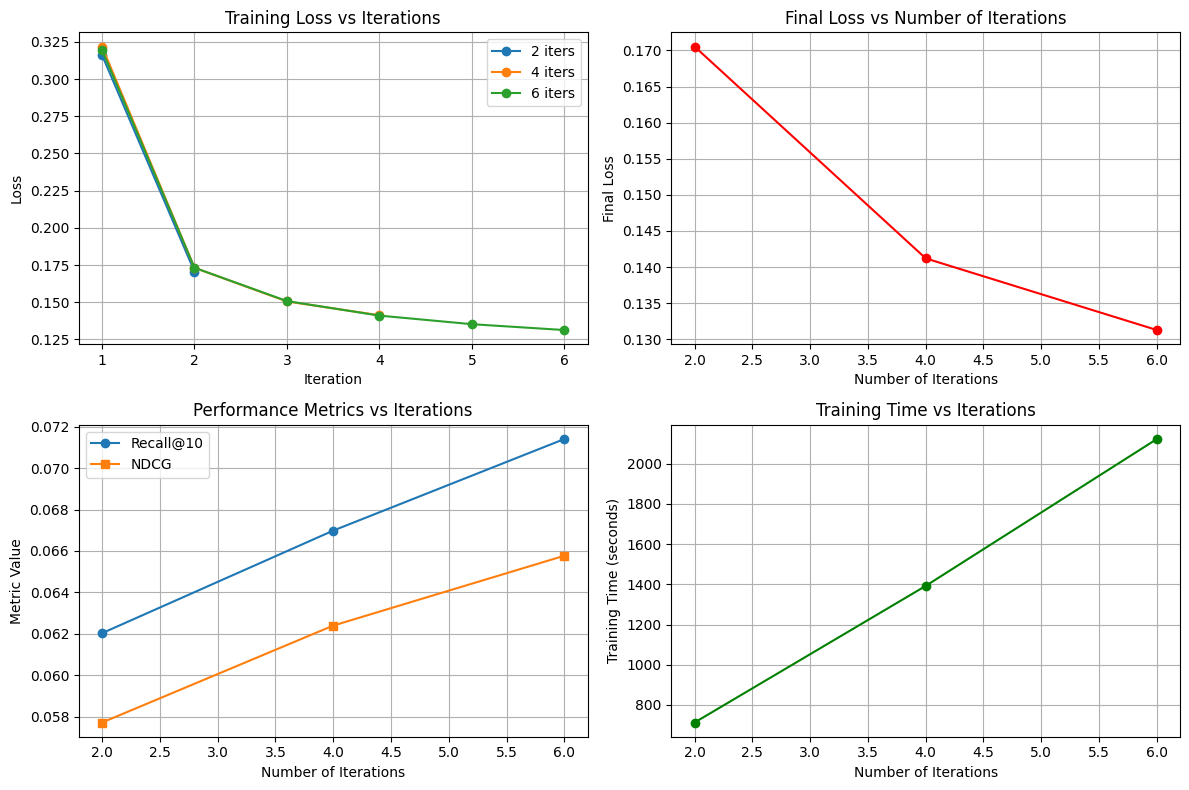

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Subplot 1: Loss curves for all iteration counts
plt.subplot(2, 2, 1)
for num_iter, losses in all_losses.items():
    plt.plot(range(1, len(losses)+1), losses, marker='o', label=f'{num_iter} iters')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.grid(True)

# Subplot 2: Final loss vs number of iterations
plt.subplot(2, 2, 2)
final_losses = [convergence_results[n]['losses'][-1] for n in iteration_counts]
plt.plot(iteration_counts, final_losses, marker='o', color='red')
plt.xlabel('Number of Iterations')
plt.ylabel('Final Loss')
plt.title('Final Loss vs Number of Iterations')
plt.grid(True)

# Subplot 3: Performance metrics vs iterations
plt.subplot(2, 2, 3)
recalls = [convergence_results[n]['recall'] for n in iteration_counts]
ndcgs = [convergence_results[n]['ndcg'] for n in iteration_counts]
plt.plot(iteration_counts, recalls, marker='o', label='Recall@10')
plt.plot(iteration_counts, ndcgs, marker='s', label='NDCG')
plt.xlabel('Number of Iterations')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs Iterations')
plt.legend()
plt.grid(True)

# Subplot 4: Training time vs iterations
plt.subplot(2, 2, 4)
times = [convergence_results[n]['time'] for n in iteration_counts]
plt.plot(iteration_counts, times, marker='o', color='green')
plt.xlabel('Number of Iterations')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs Iterations')
plt.grid(True)

plt.tight_layout()
plt.savefig('als_convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

From the plots, we can say after **`iteration=4` provides the most significant improvement in my model** and after that, the improvement starts to become less significant. That is why `iteration=4` can be used as the parameter from training ALS.

## Q4 Matrix Factorization- PLRec

PLRec Algorithm

In [84]:
def plrec(matrix_train, embeded_matrix=np.empty((0)), iteration=4, lam=80, rank=200, seed=1, **unused):
    """
    Function used to achieve generalized projected lrec w/o item-attribute embedding
    :param matrix_train: user-item matrix with shape m*n
    :param embeded_matrix: item-attribute matrix with length n (each row represents one item)
    :param lam: parameter of penalty
    :param k_factor: ratio of the latent dimension/number of items
    :return: prediction in sparse matrix
    """
    matrix_input = matrix_train
    if embeded_matrix.shape[0] > 0:
        matrix_input = vstack((matrix_input, embeded_matrix.T))


    P, sigma, Qt = randomized_svd(matrix_input,
                                  n_components=rank,
                                  n_iter=iteration,
                                  random_state=seed)

    RQ = matrix_input.dot(sparse.csc_matrix(Qt.T*np.sqrt(sigma)))

    print("RQ shape:", RQ.shape)
    print("P shape:", P.shape)
    print("sigma shape:", sigma.shape)
    print("Qt shape:", Qt.shape)



    start_time = time.time()
    pre_inv = RQ.T.dot(RQ) + lam * sparse.identity(rank, dtype=np.float32)
    inverse = inv(pre_inv)
    Y = inverse.dot(RQ.T).dot(matrix_input)
    print("Elapsed: {0}".format(time.time() - start_time))
    return np.array(RQ.todense()), np.array(Y.todense()), None


### a) In this question we are going to solve Matrix Factorization (MF) using another algorithm, named as Projected Linear Recommendation (PLRec). The code for the assignment is provided. You need to predict and evaluate performance. Insert the necessary code in the designated section to make predictions. Run your implemented matrix factorization model on the movielens 20M dataset. (2 Pt)

In [85]:
# Parameters for PLRec
iteration = 4
lam = 80
rank = 200
topK = 10
sim_measure = 'Cosine'

In [86]:
# Run experiment
start_time = time.time()
RQ_plrec, Y_plrec, Bias_plrec = plrec(
    rtrain, 
    embeded_matrix=np.empty((0)),
    iteration=iteration, 
    lam=lam, 
    rank=rank, 
    seed=1
)
training_time = time.time() - start_time

print(f"\nPLRec Training completed in {training_time:.2f} seconds")

RQ shape: (138362, 200)
P shape: (138362, 200)
sigma shape: (200,)
Qt shape: (200, 22884)
Elapsed: 21.447603225708008

PLRec Training completed in 33.73 seconds


In [89]:
print("\nPredictions using the PLRec model...")
start_time = time.time()
prediction_plrec = predict(
    matrix_U=RQ_plrec,
    matrix_V=Y_plrec.T,
    bias=Bias_plrec,
    topK=topK,
    matrix_Train=rtrain,
    measure=sim_measure
)
prediction_time = time.time() - start_time
print(f"Predictions completed in {prediction_time:.2f} seconds")

# Sample predictions for first 5 users
print("\nSample Predictions (Top 5 items for first 5 users):")
print("-"*50)
for user_idx in range(5):
    top_items = prediction_plrec[user_idx][:5]
    print(f"User {user_idx}: {top_items}")


Predictions using the PLRec model...


100%|█████████████████████████████████████████████████████████████████████████| 138362/138362 [03:40<00:00, 627.60it/s]


Predictions completed in 220.68 seconds

Sample Predictions (Top 5 items for first 5 users):
--------------------------------------------------
User 0: [ 950 1896 6726 8143 1313]
User 1: [ 905 3382 1341  886 1174]
User 2: [1205 2712 1066  885 1361]
User 3: [ 496  183  581  363 1660]
User 4: [791  10 504 788 591]


In [93]:
# Checking the moview title to compare with the popularity recomendor earlier
print("\nPLRec Recommendations:")
print("-"*80)

for user_idx in range(5):
    top_items_indices = prediction_plrec[user_idx][:5].astype(int)
    
    print(f"User {user_idx + 1}:")
    for item_idx in top_items_indices:
        movie_id = int(sorted_movie_ids[item_idx])
        if movie_id in movie_id_to_title:
            print(f"  - {movie_id}: {movie_id_to_title[movie_id]}")
        else:
            print(f"  - {movie_id}")


PLRec Recommendations:
--------------------------------------------------------------------------------
User 1:
  - 967: Outlaw, The (1943)
  - 1980: Friday the 13th Part VII: The New Blood (1988)
  - 6836: Amazing Transparent Man, The (1960)
  - 8826: Human Resources (Ressources humaines) (1999)
  - 1343: Cape Fear (1991)
User 2:
  - 922: Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
  - 3471: Close Encounters of the Third Kind (1977)
  - 1372: Star Trek VI: The Undiscovered Country (1991)
  - 903: Vertigo (1958)
  - 1199: Brazil (1985)
User 3:
  - 1232: Stalker (1979)
  - 2798: Problem Child (1990)
  - 1088: Dirty Dancing (1987)
  - 902: Breakfast at Tiffany's (1961)
  - 1392: Citizen Ruth (1996)
User 4:
  - 500: Mrs. Doubtfire (1993)
  - 185: Net, The (1995)
  - 587: Ghost (1990)
  - 367: Mask, The (1994)
  - 1720: Time Tracers (1995)
User 5:
  - 804: She's the One (1996)
  - 11: American President, The (1995)
  - 508: Philadelphia (1993)
  - 801: Harriet the Spy (1996)
  - 597: Pr

This shows the **PLRec is able to capture the individual preference of users**. For example, **user 5 is recomended romantic and drama films, user 4 is recomended comedy and drama films**. More explanation comming in `Q4.b.ii`

### (b) Answer the following questions:

#### i. Show the performance of your PLRec implementation. (2 Pt)

In [104]:
metric_names = ['R-Precision', 'NDCG', 'Clicks', 'Recall', 'Precision']
result_plrec = evaluate(prediction_plrec, rvalid, metric_names, atK=[topK])

print("\nPLRec Performance Metrics:")
print("-"*40)
for metric in result_plrec.keys():
    value, std = result_plrec[metric]
    print(f"{metric}: {value:.4f} (±{std:.4f})")

100%|████████████████████████████████████████████████████████████████████████| 138362/138362 [00:33<00:00, 4115.43it/s]


PLRec Performance Metrics:
----------------------------------------
Recall@10: 0.0738 (±0.0007)
Precision@10: 0.0784 (±0.0006)
NDCG: 0.0731 (±0.0006)
Clicks: 2.8087 (±0.0124)
R-Precision: 0.0520 (±0.0005)


#### ii. Compared to the given ALS models, does PLRec take long or less time to train? Does it perform better than the given baseline models? (3 Pt)

The **PLRec leverages randmized SVD which can handel the sparse metric more faster than ALS**, an iterative approach. For this reason, it took only `33.73 seconds`, whereas the ALS too `1400 seconds` for `4 iterations`.   

Comparing the PLRec with the baseline models, we can say it did significantly better than the popularity model because the PLRec is able to personalize the recomendation list as per users' prefernce and choice, but the popularity recomender only provided the recomendation based on global popularity of a movie. 

Since I could not run the `user-user similarity` based recomender, I can not explicitely comment on whether PLRec would outperform it or not in terms of recomendation. But it is certain thatt PLRec is by far the most practical model we have used in our assignment 1 and 2.
